In [1]:
from progressbar import progressbar
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
from Simulations.odeSolver.doubleS import rxnNetwork, labels
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

In [4]:
def get_pBound_numerically(KPP, parmGen, solver:str):
    parm = parmGen(KPP)
    if solver=='doubleS':
        equi = numericSolver(parm_df=parm, labels=labels, model=rxnNetwork, ifprint=False)
        pBound = num.calc_BoundRatio_modelC(parm.iloc[0], equi.iloc[0])
    elif solver=='singleS':
        equi = numericSolver(parm_df=parm, labels=labelsSingleS, model=rxnSingleS, ifprint=False)
        pBound = num.calc_BoundRatio_modelB(parm.iloc[0], equi.iloc[0])
    return pBound

def solve_KPP_half(gamma, solver:str, KPN, KPS=lambda KPN: 2e3, ifprint=False):

    from scipy import optimize
    
    parmGen = lambda KPP: GenParameters( # Here KPP must be iterable
        numTargets=2, KPN=[KPN], KPS=KPS, 
        NP0=[0.03], KPP=KPP, gamma=[gamma],
    )
    sample_parm = parmGen([0])
    CP0_M = sample_parm['CP0'].unique() / 0.6022
    pBound_mon = get_pBound_numerically([0], parmGen, solver)
    pBound_irr = get_pBound_numerically([np.inf], parmGen, solver)
    half_pBound = (pBound_mon + pBound_irr) / 2
    
    if ifprint:
        print('half fraction:', half_pBound)
        print('fraction with KPP=1e6:', get_pBound_numerically([1e6], parmGen, solver))
    
    target_function = lambda logKPP: get_pBound_numerically([10**(logKPP)], parmGen, solver) - half_pBound
    logkpp = optimize.root_scalar(target_function, bracket=[0,9]).root
    return 10**(logkpp)*CP0_M
    

In [5]:
KPNlist = np.logspace(1, 3, 5+4*10)*2.0
gammalist = np.logspace(0,3, 4+3*5)

XPP_half_singleS = []
XPP_half_doubleS = []

for gamma in progressbar(gammalist):
    kpn = 20
    XPP_half_singleS.append(solve_KPP_half(gamma, 'singleS', kpn))
    XPP_half_doubleS.append(solve_KPP_half(gamma, 'doubleS', kpn))
XPP_half_singleS = np.array(XPP_half_singleS)
XPP_half_doubleS = np.array(XPP_half_doubleS)

100% (19 of 19) |########################| Elapsed Time: 0:00:44 Time:  0:00:44


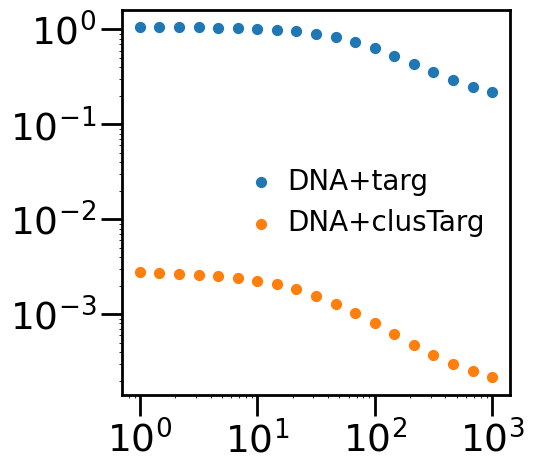

In [6]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, _, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc='best', lgdFontSize=20, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=20,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
markerSize=50
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

ax.scatter(gammalist, XPP_half_singleS, label='DNA+targ', s=markerSize)
ax.scatter(gammalist, XPP_half_doubleS, label='DNA+clusTarg', s=markerSize)

plt.legend(**legend)
plt.loglog()

plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.show()